In [42]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json

In [43]:
#Loading data
df = pd.read_csv("sample_data/Life_Expectancy_Data.csv")

In [44]:
#Initial checks
print(df.head())
print(df.shape)
print(df.info())

       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.

In [45]:
#Missing values summary
print(df.isnull().sum())
print(df.isnull().sum() / df.shape[0] * 100)

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64
Country                             0.000000
Year                                0.000000
Status                              0.0

In [46]:
#Checking duplicate values
print("Duplicate Rows: ", df.duplicated().sum())

Duplicate Rows:  0


In [47]:
#Checking garbage values
for col in df.select_dtypes(include="object").columns:
    print(f"{col}:\n{df[col].value_counts()}")
    print("***" * 10)

Country:
Country
Afghanistan              16
Albania                  16
Algeria                  16
Angola                   16
Antigua and Barbuda      16
                         ..
Monaco                    1
Marshall Islands          1
Saint Kitts and Nevis     1
San Marino                1
Tuvalu                    1
Name: count, Length: 193, dtype: int64
******************************
Status:
Status
Developing    2426
Developed      512
Name: count, dtype: int64
******************************


In [48]:
#Descriptive Statistics
print(df.describe().T)
print(df.describe(include="object"))

                                  count          mean           std  \
Year                             2938.0  2.007519e+03  4.613841e+00   
Life expectancy                  2928.0  6.922493e+01  9.523867e+00   
Adult Mortality                  2928.0  1.647964e+02  1.242921e+02   
infant deaths                    2938.0  3.030395e+01  1.179265e+02   
Alcohol                          2744.0  4.602861e+00  4.052413e+00   
percentage expenditure           2938.0  7.382513e+02  1.987915e+03   
Hepatitis B                      2385.0  8.094046e+01  2.507002e+01   
Measles                          2938.0  2.419592e+03  1.146727e+04   
 BMI                             2904.0  3.832125e+01  2.004403e+01   
under-five deaths                2938.0  4.203574e+01  1.604455e+02   
Polio                            2919.0  8.255019e+01  2.342805e+01   
Total expenditure                2712.0  5.938190e+00  2.498320e+00   
Diphtheria                       2919.0  8.232408e+01  2.371691e+01   
 HIV/A

In [49]:
#Cleaning column names
df.columns=df.columns.str.strip()

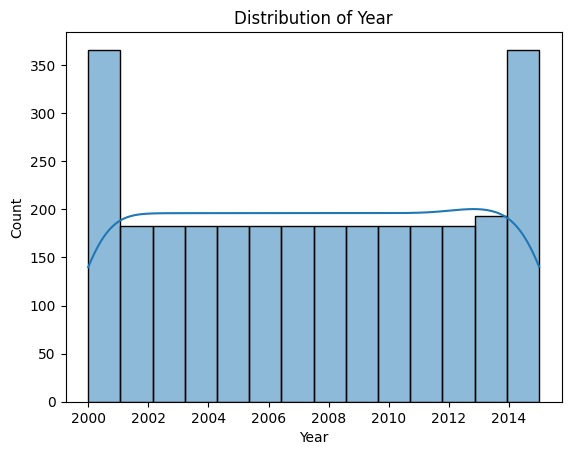

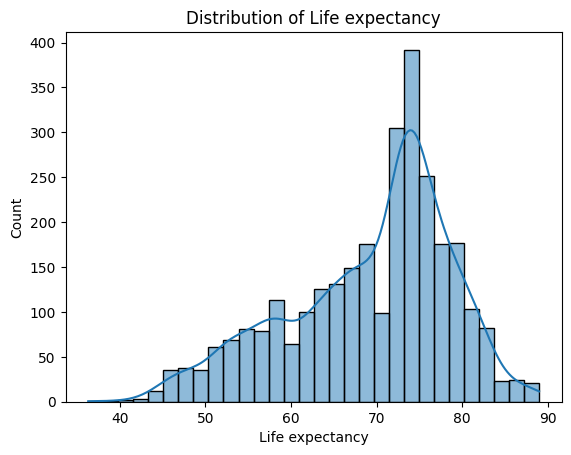

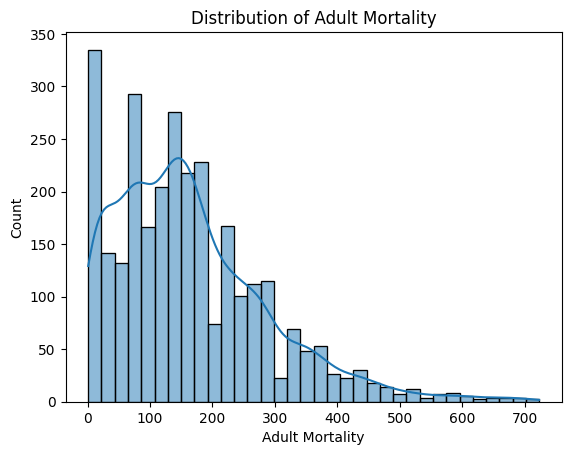

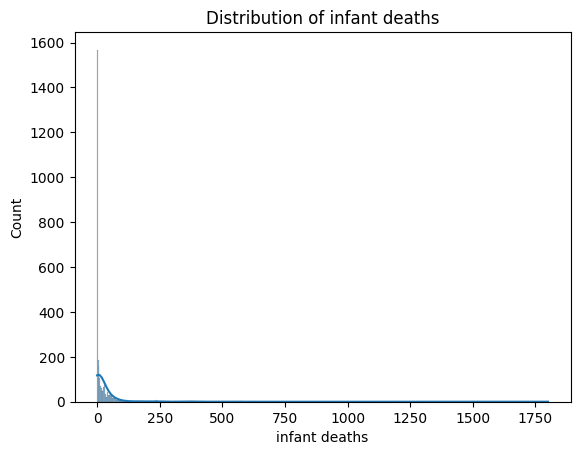

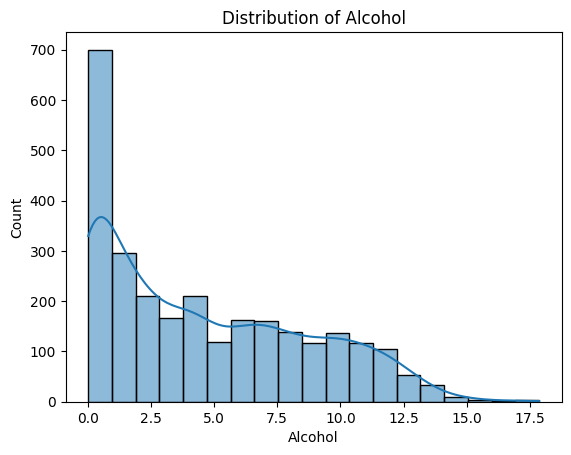

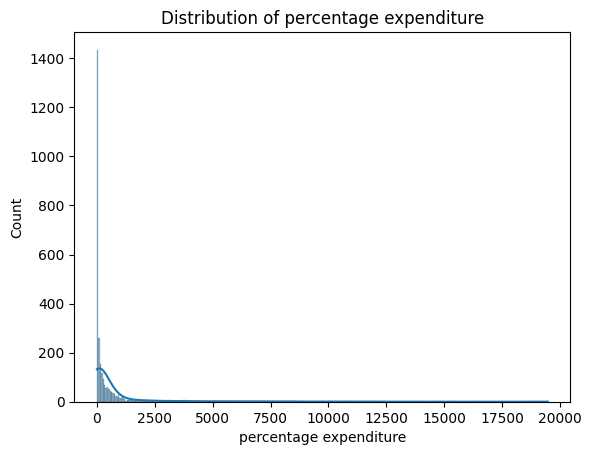

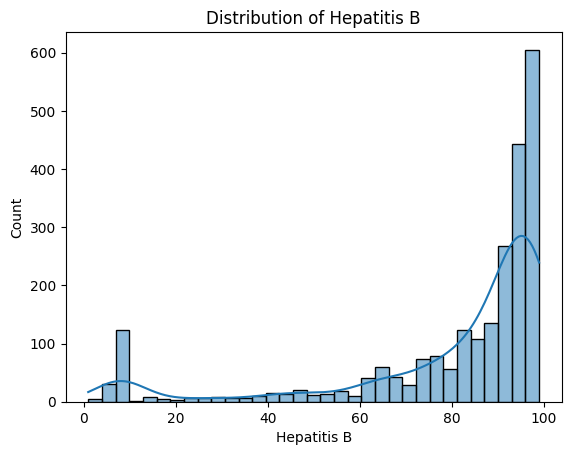

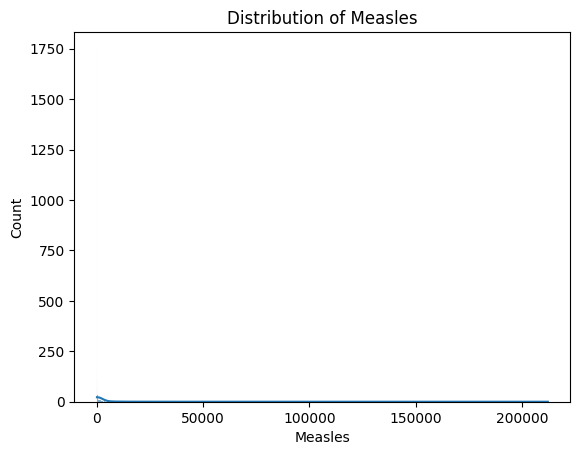

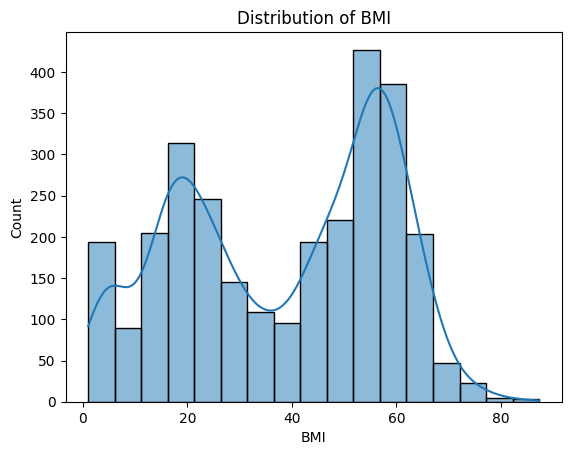

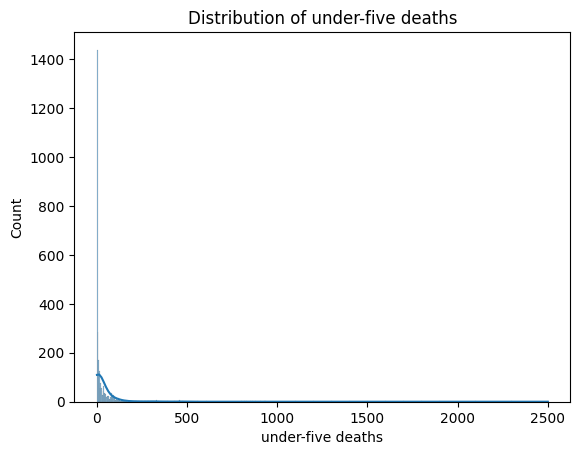

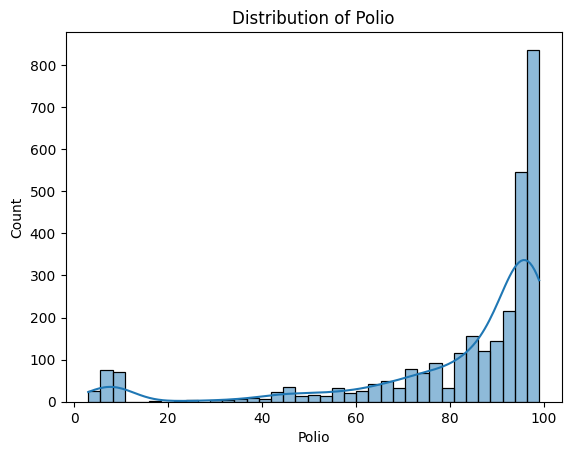

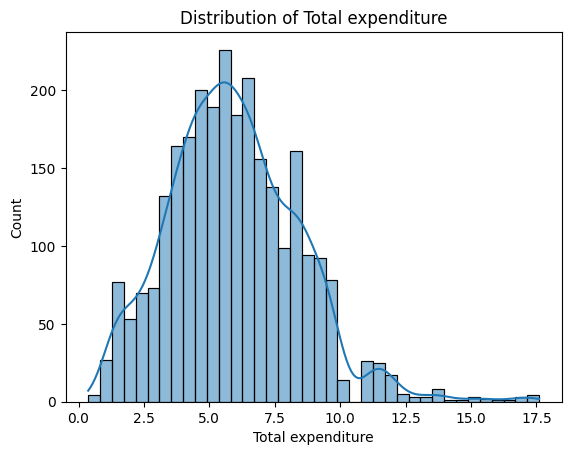

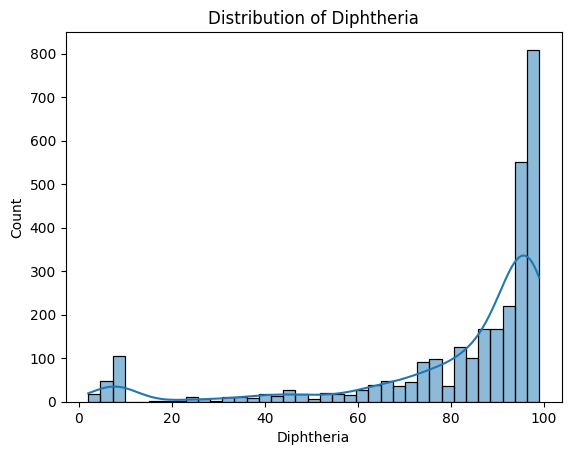

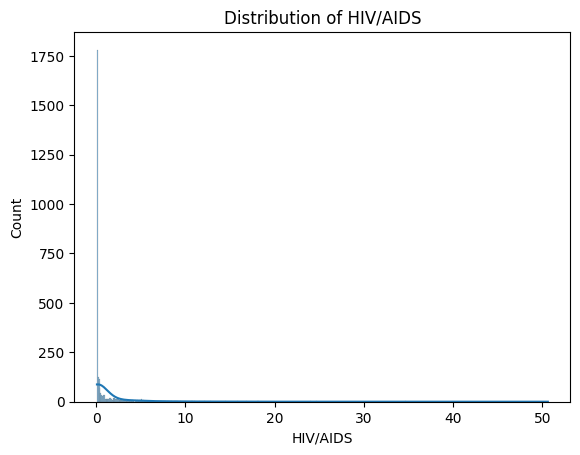

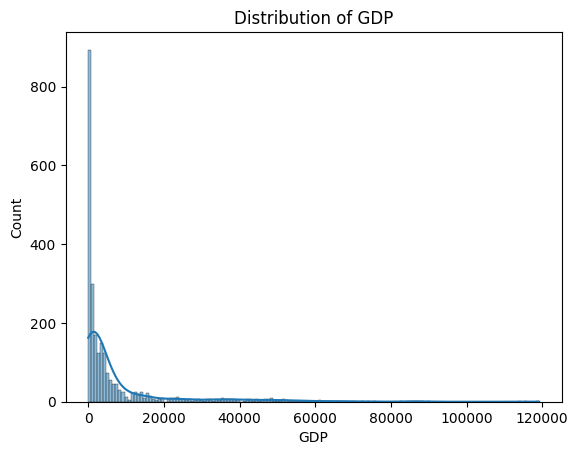

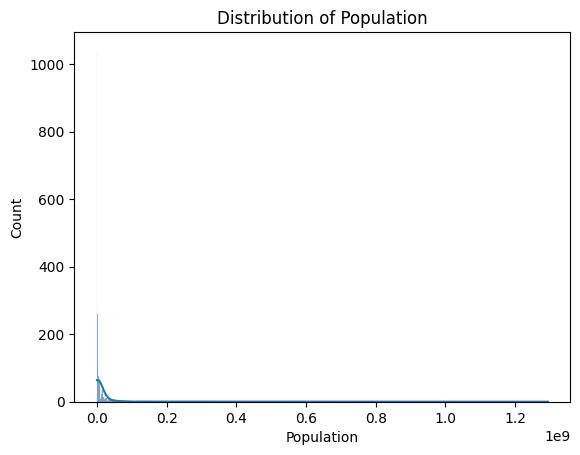

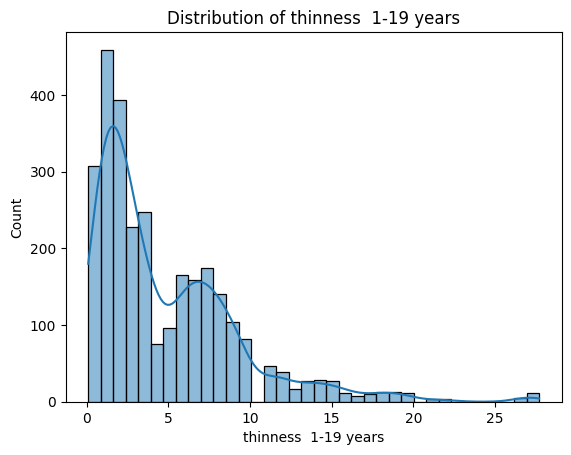

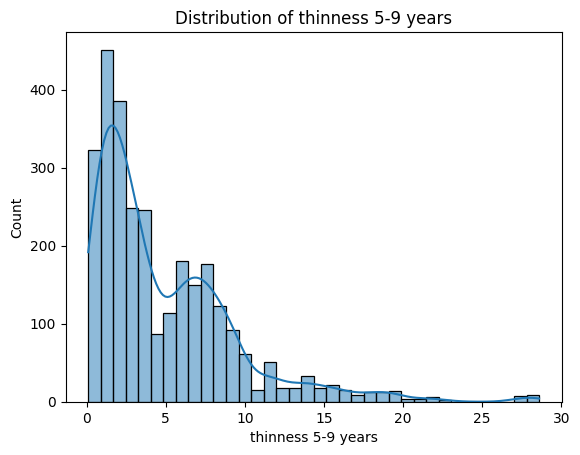

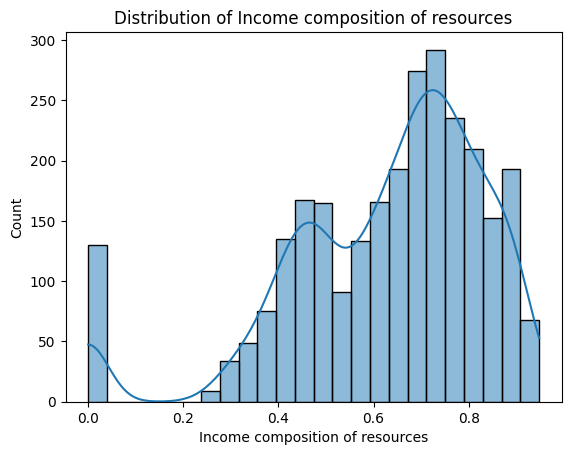

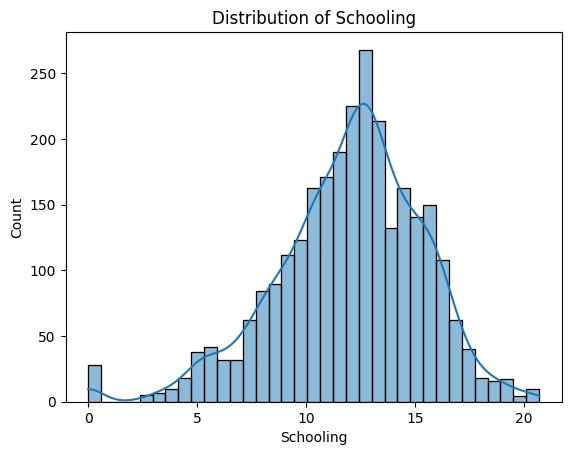

In [50]:
#Histograms
for col in df.select_dtypes(include="number").columns:
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

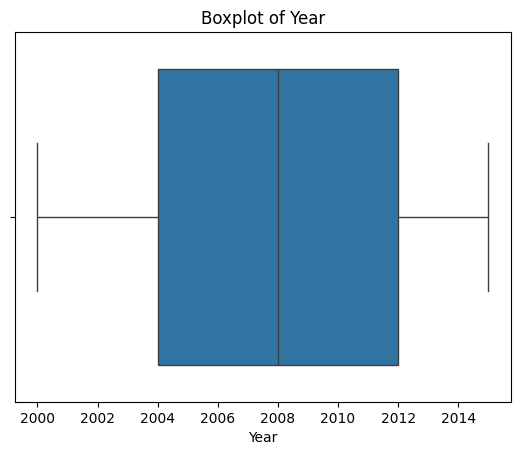

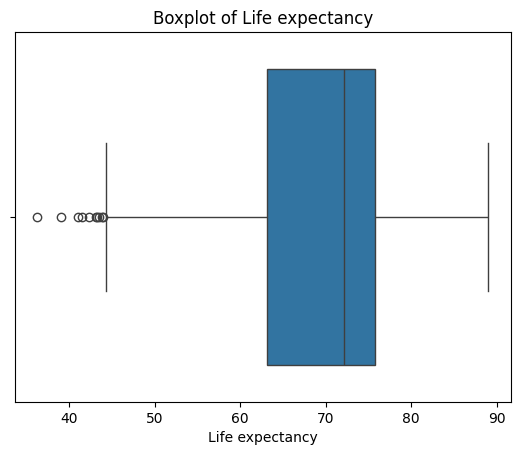

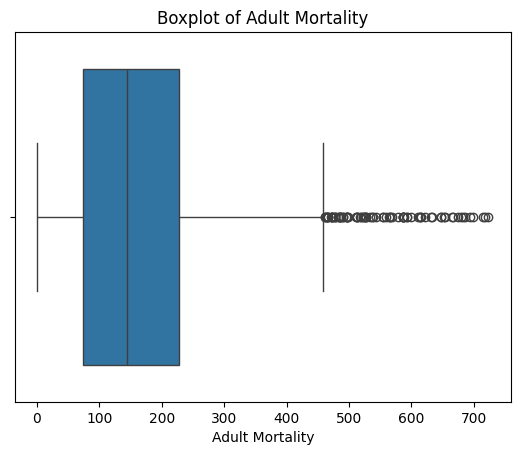

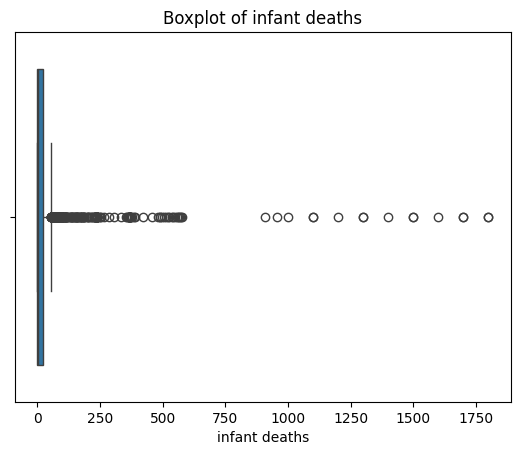

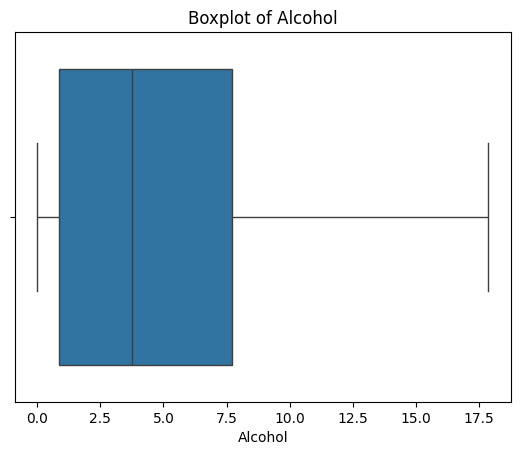

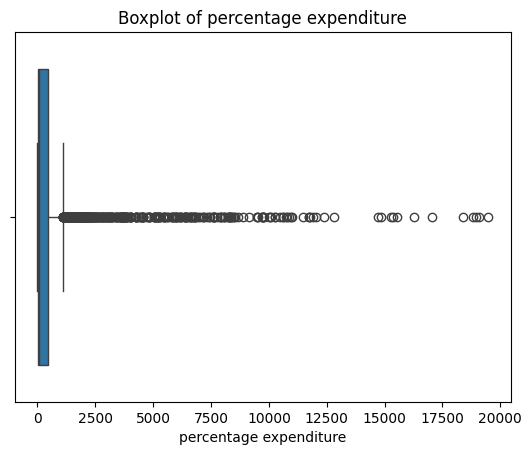

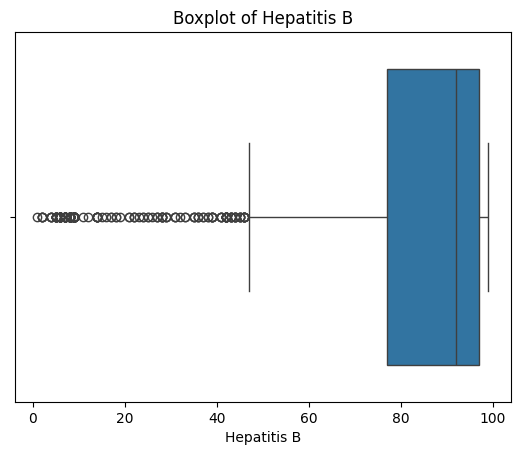

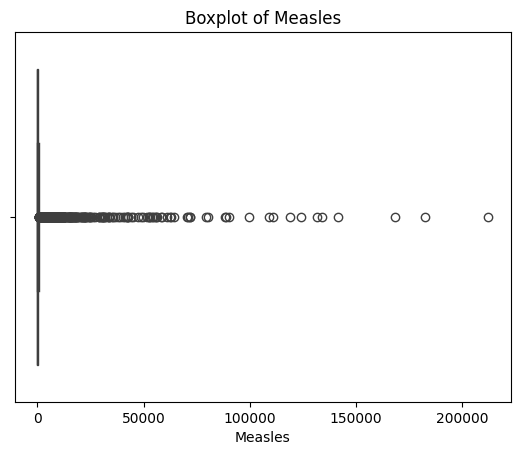

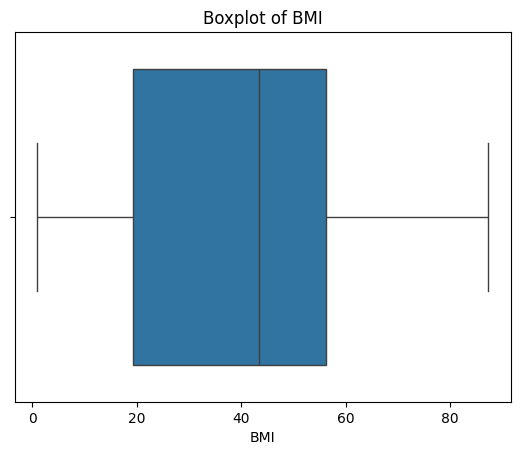

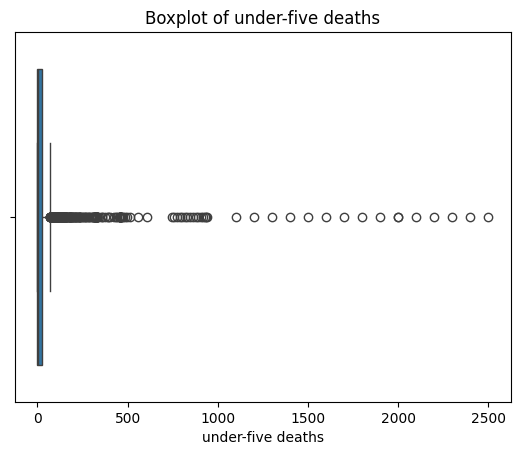

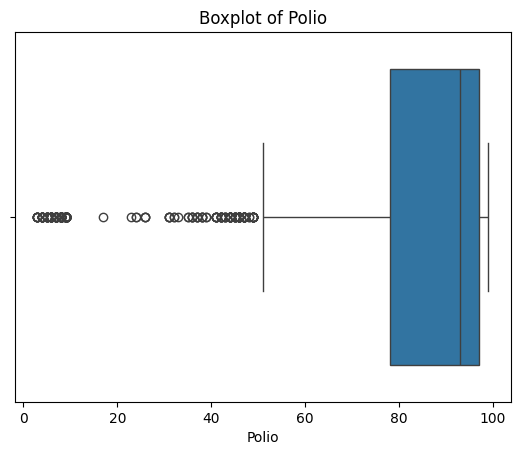

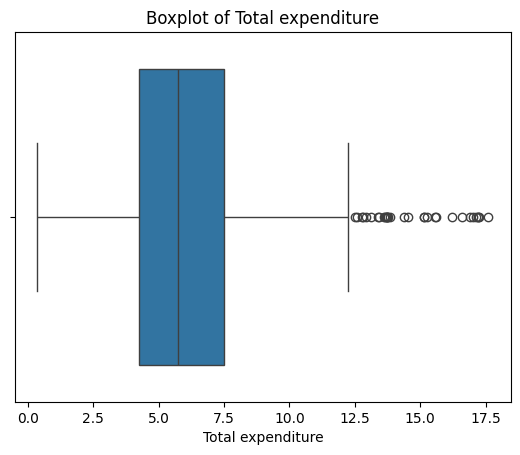

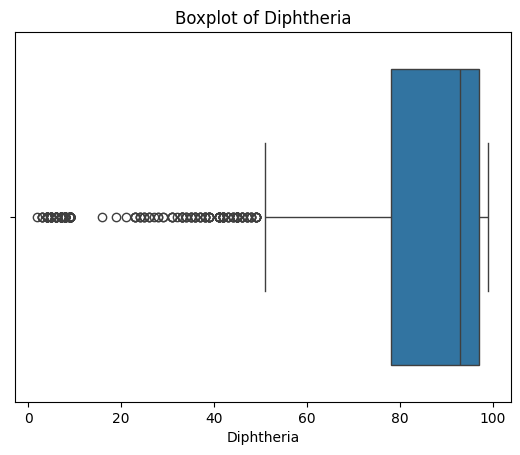

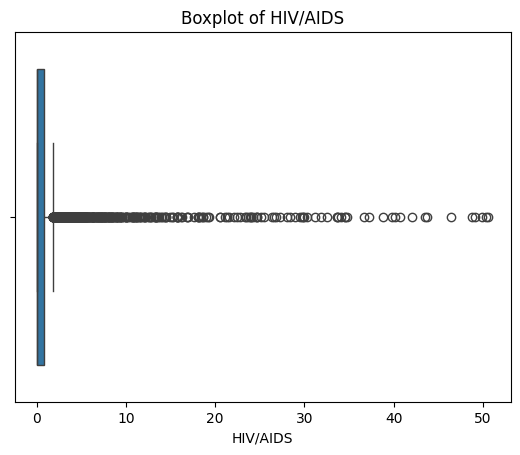

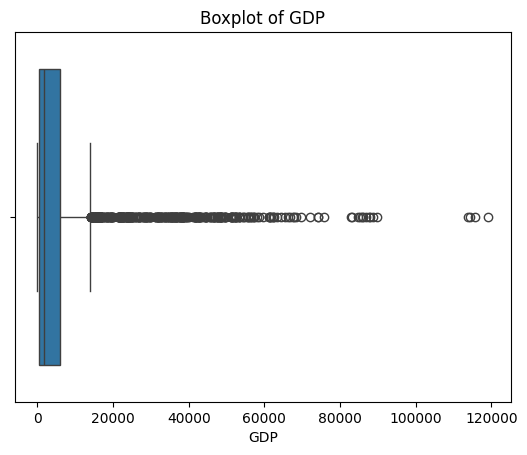

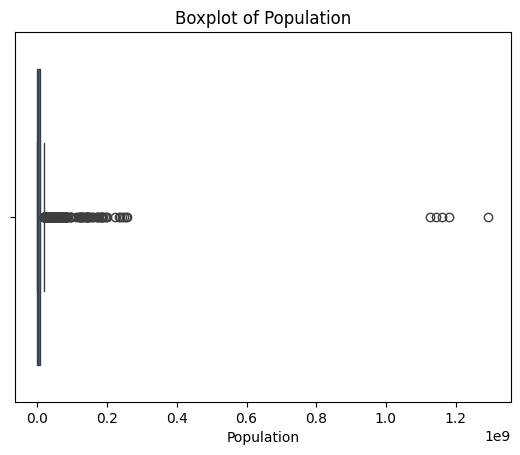

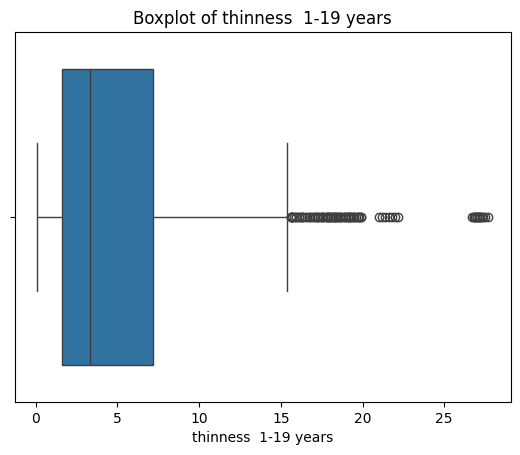

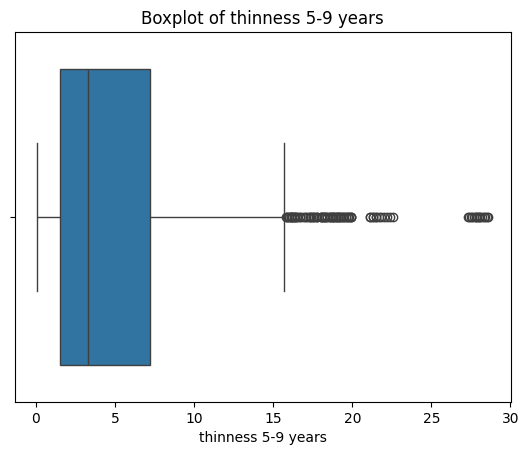

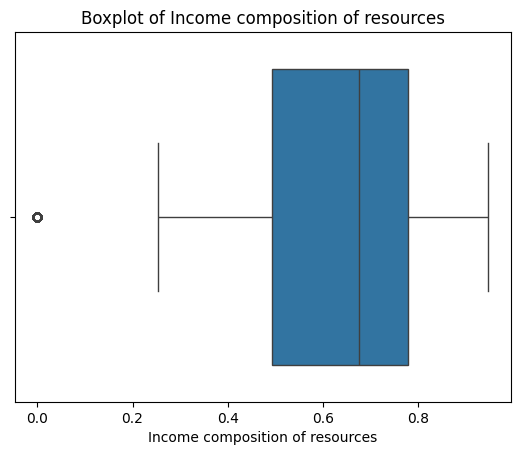

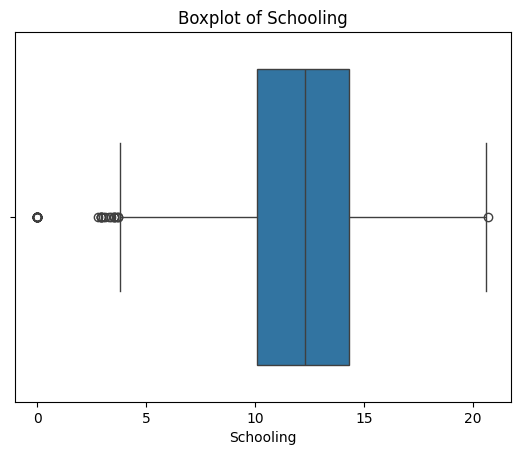

In [51]:
#Boxplots
for col in df.select_dtypes(include="number").columns:
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

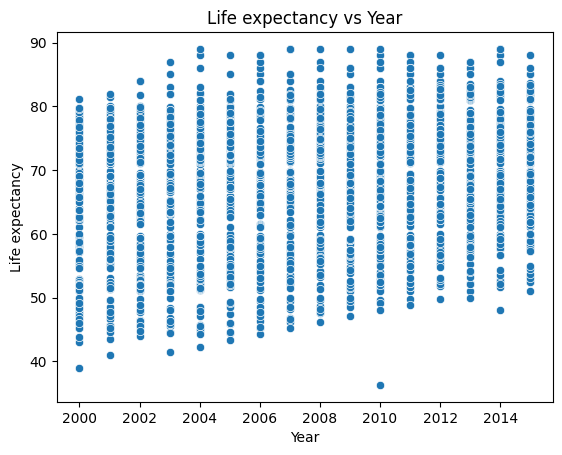

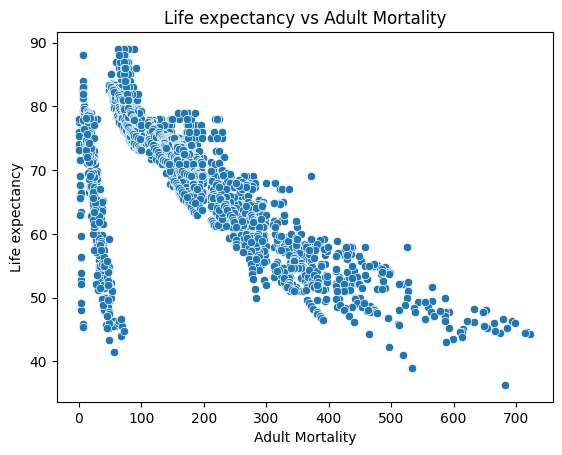

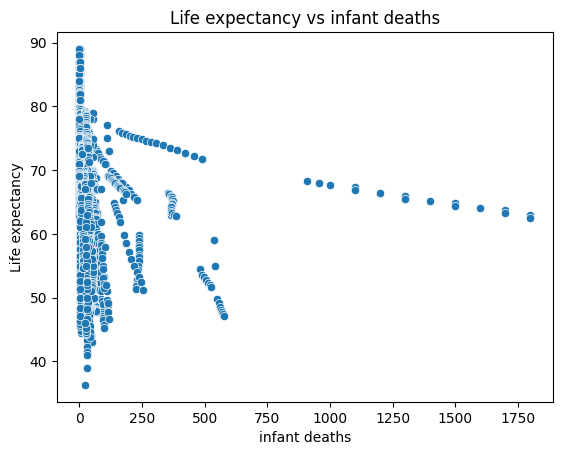

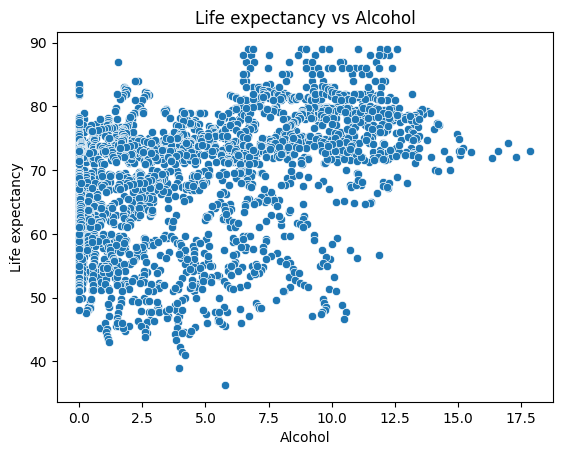

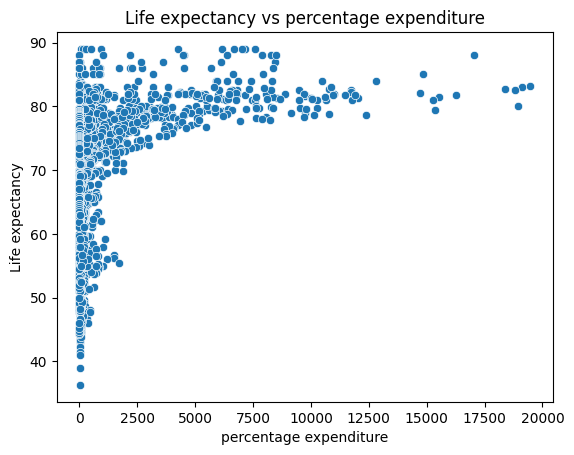

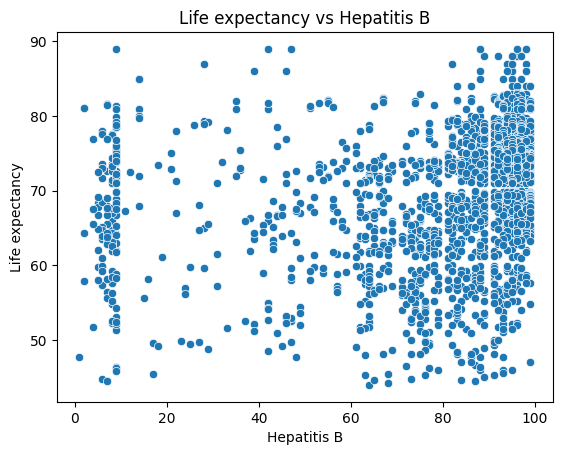

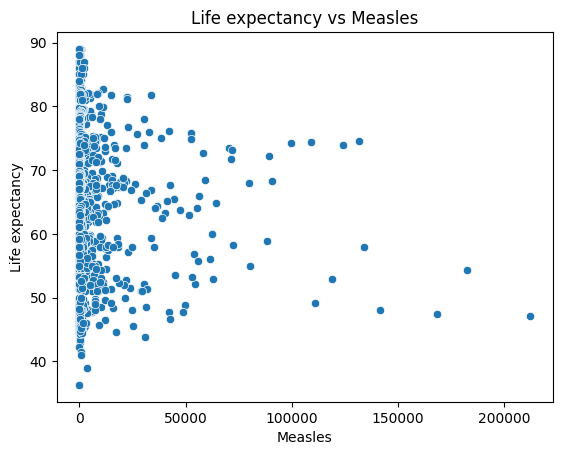

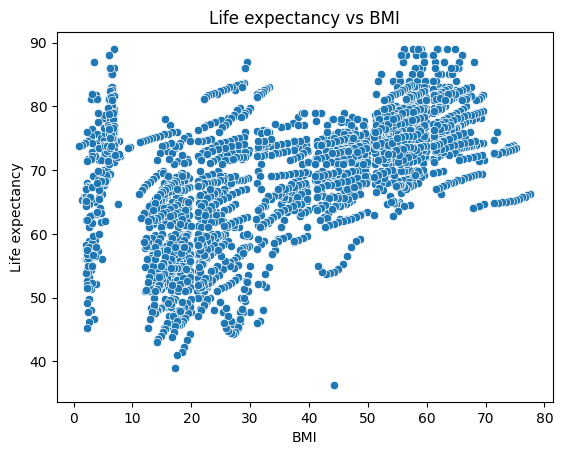

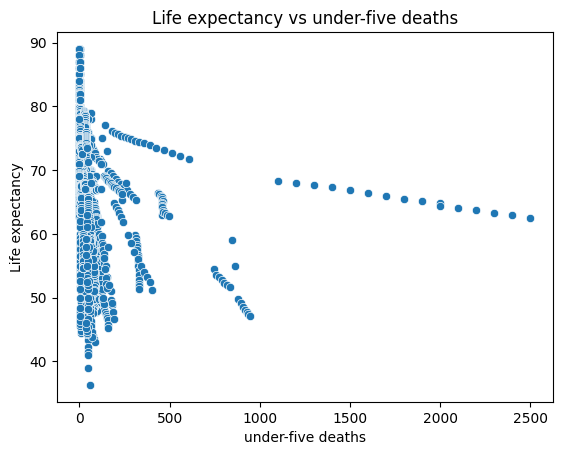

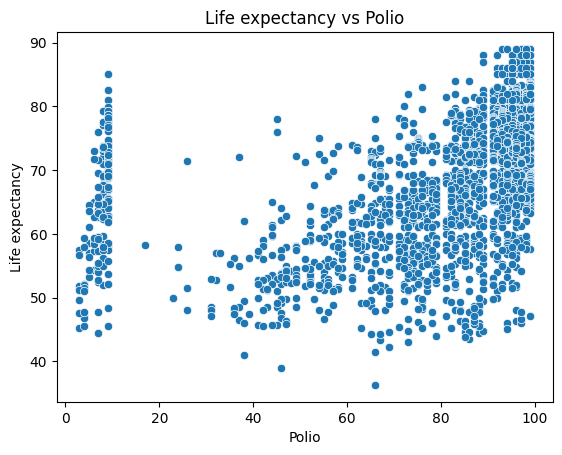

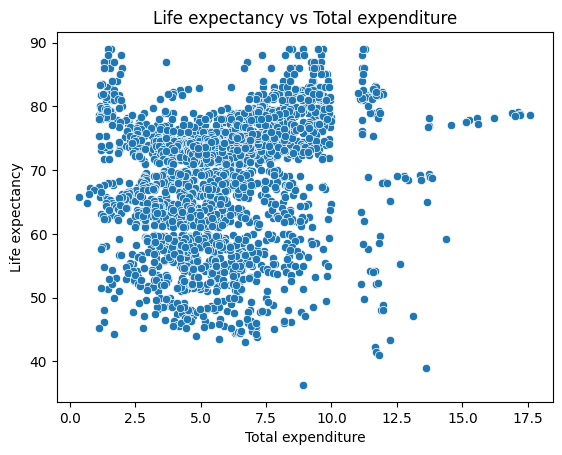

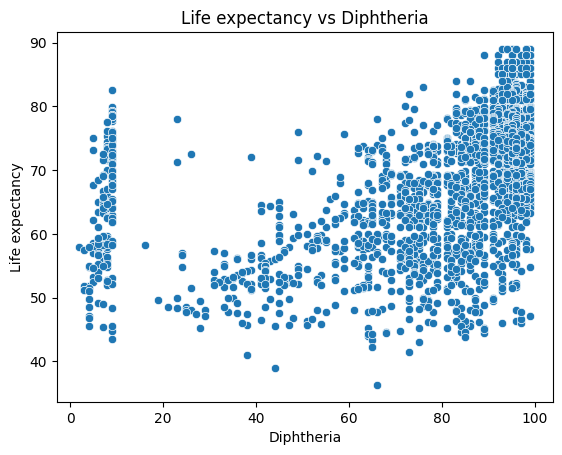

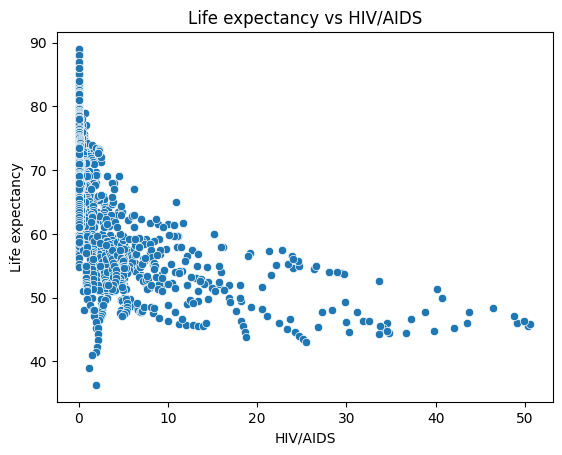

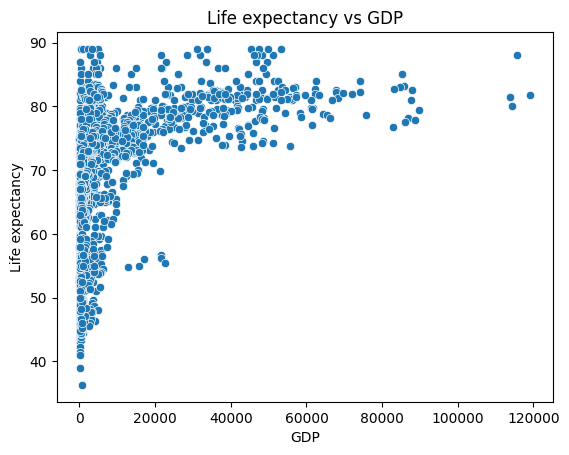

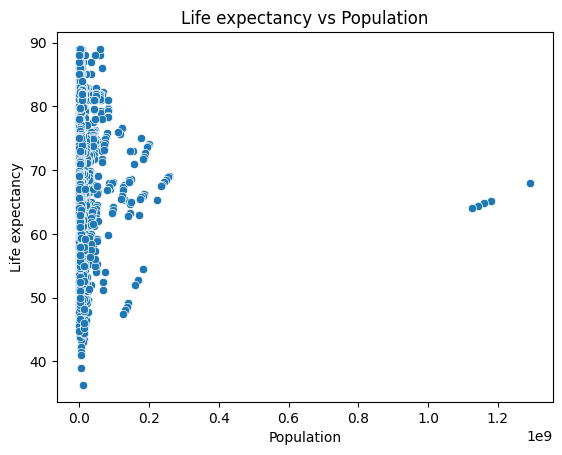

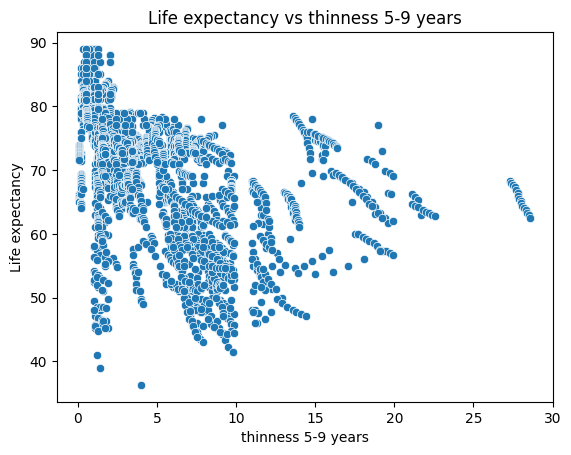

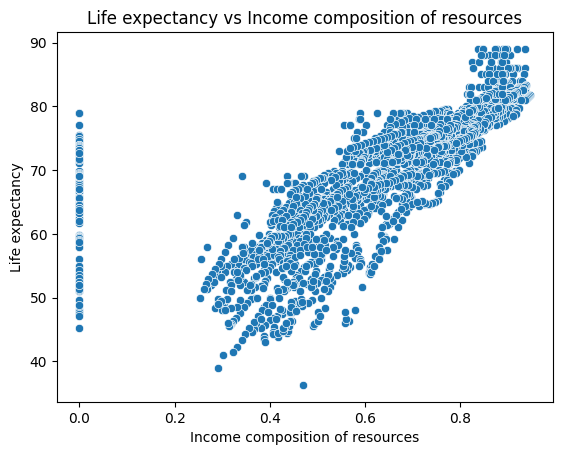

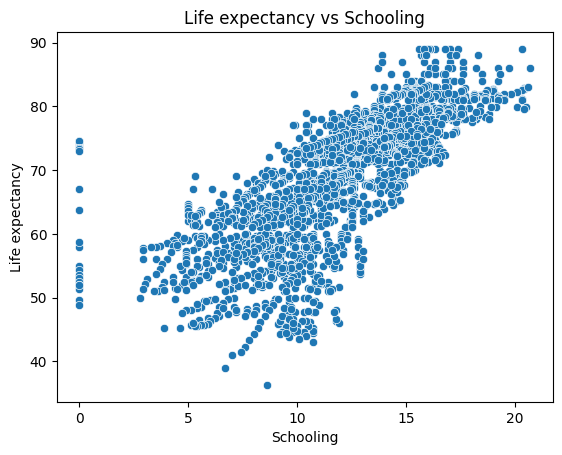

In [52]:
#Scatterplots with life expectancy
columns_to_plot = [
    'Year', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
    'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
    'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
    'thinness 1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling'
]

for col in columns_to_plot:
    if col in df.columns:
        sns.scatterplot(data=df, x=col, y='Life expectancy')
        plt.title(f'Life expectancy vs {col}')
        plt.show()

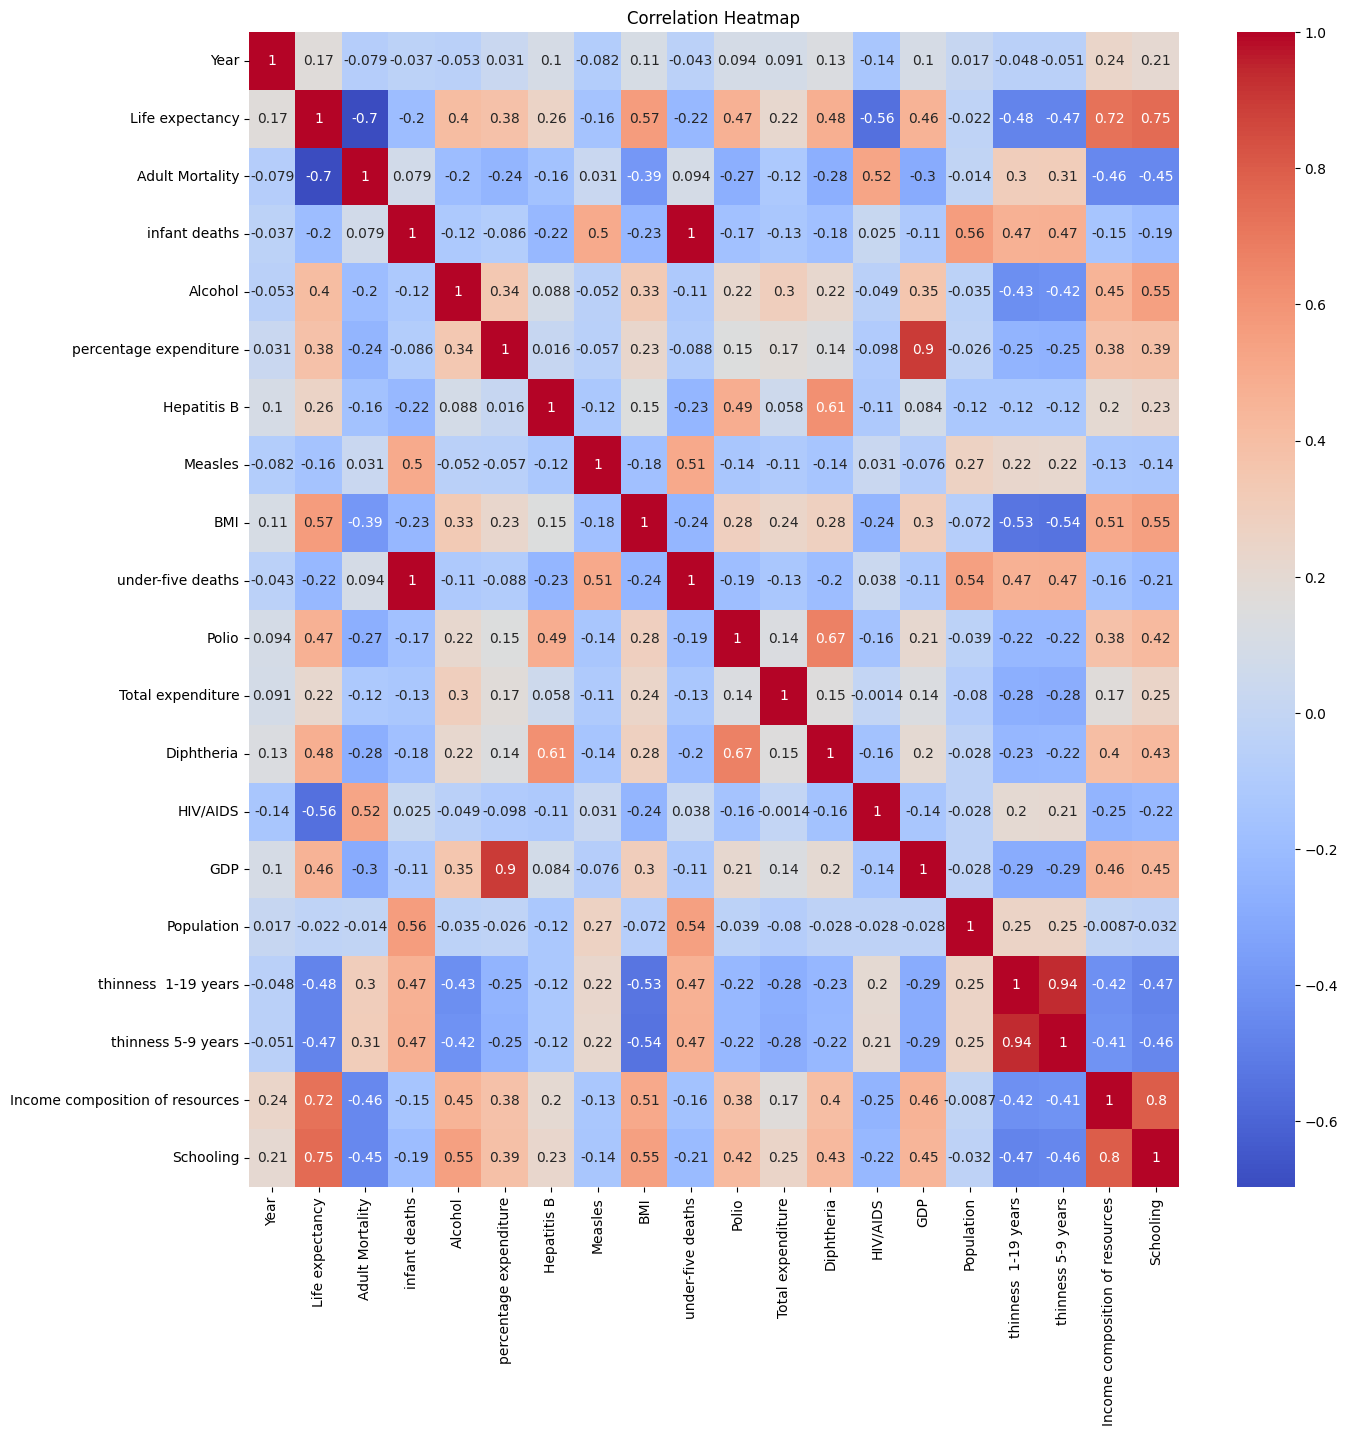

In [53]:
#Correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df.select_dtypes(include="number").corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [54]:
#Median Imputation for some columns
for col in ["BMI", "Polio", "Income composition of resources"]:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

In [55]:
#KNN Imputer for remaining numerical columns
imputer = KNNImputer()
df[df.select_dtypes(include="number").columns] = imputer.fit_transform(df.select_dtypes(include="number"))

In [56]:
#Outlier treatment using Whisker method
def wisker(col):
    q1, q3 = np.percentile(col, [25, 75])
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    return lw, uw

# Make column names lowercase
df.columns = df.columns.str.lower()

# Outlier columns
outlier_cols = ['gdp', 'total expenditure', 'thinness  1-19 years', 'thinness 5-9 years']
outlier_cols = [col.strip().lower() for col in outlier_cols]

for col in outlier_cols:
    if col in df.columns:
        lw, uw = wisker(df[col])
        df[col] = np.where(df[col] < lw, lw, df[col])
        df[col] = np.where(df[col] > uw, uw, df[col])

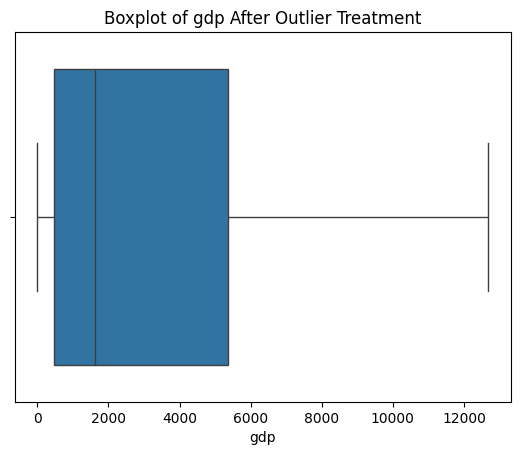

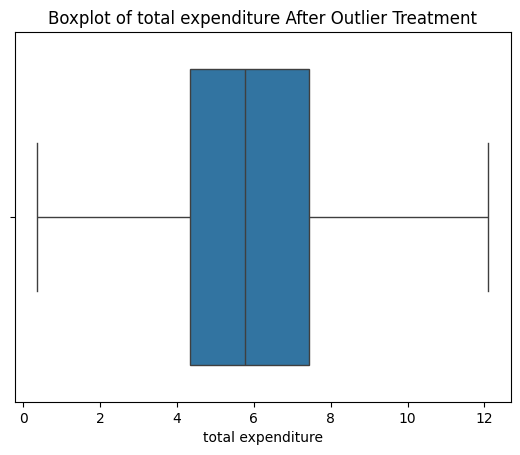

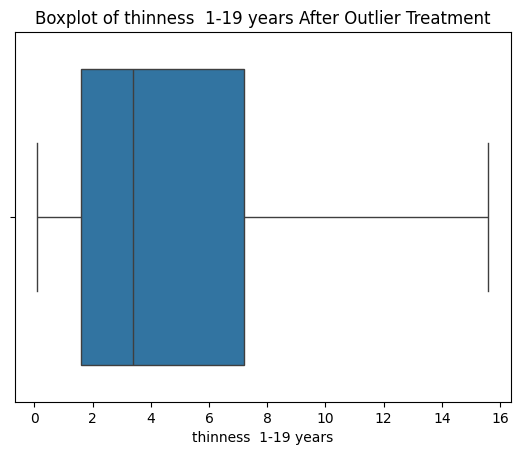

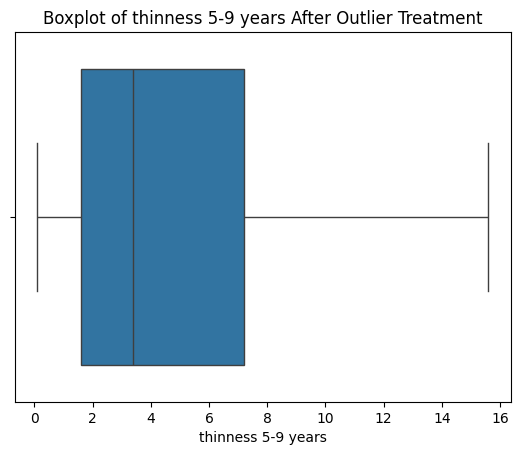

In [57]:
#Boxplots after outlier treatment
for col in outlier_cols:
  if col in df.columns:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col} After Outlier Treatment')
    plt.show()

In [58]:
#Check for 'country' and 'status' columns before encoding
df.columns = df.columns.str.strip()

if 'country' in df.columns and 'status' in df.columns:
    df_encoded = pd.get_dummies(df, columns=["country", "status"], drop_first=True)
else:
    print("Warning: 'country' or 'status' column not found. Skipping encoding.")
    df_encoded = df.copy()

In [59]:
#Final dataset overview
print("Final Dataset Shape:",df_encoded.shape)

Final Dataset Shape: (2938, 213)


#**Model Training**

In [60]:
#Split features and target
X = df_encoded.drop('life expectancy', axis=1)
y = df_encoded['life expectancy']

In [61]:
#Saving the feature column names for later use in prediction (Streamlit):
feature_columns = X.columns.tolist()
with open('feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)

In [62]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
#Train Linear Regression Model
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [64]:
#Predictions
y_pred = model.predict(X_test)

In [65]:
#Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📊 Model Evaluation:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)

📊 Model Evaluation:
MAE: 1.186912233554437
MSE: 3.450404560293934
RMSE: 1.8575264628785062
R² Score: 0.960173873590168


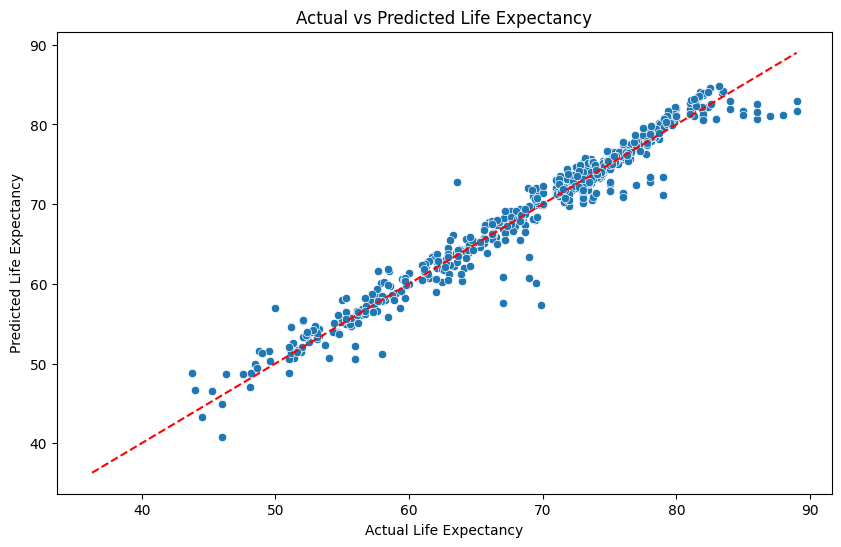

In [66]:
#Visualization of predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Actual vs Predicted Life Expectancy")
plt.show()

In [67]:
#Saving the trained model
joblib.dump(model, 'life_expectancy_model.pkl')
print("✅ Model saved as 'life_expectancy_model.pkl'")

✅ Model saved as 'life_expectancy_model.pkl'
